In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils.tree import QPLTree
from src.utils.schema import DBSchema, NoiseStrategy
from datasets import load_dataset

/Users/dani/Documents/school/finetune_llm/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
schemas = DBSchema.from_db_schemas_file()

In [4]:
completer_ds = load_dataset("d4nieldev/qpl-completer-ds")

In [ ]:
import numpy as np

original = []
noise_levels = np.linspace(0, 1, 20)
linked = [[] for _ in noise_levels]
for split in completer_ds:
    data = completer_ds[split]
    for d in data:
        db_id = d['db_id']
        schema = schemas[db_id]
        original.append(schema)
        qpl_lines = []
        if d['prefix_qpl']:
            qpl_lines.extend([line.split(' ; ')[0] for line in d['prefix_qpl'].split('\n')])
        qpl_lines.append(d['qpl_line'])
        qpl_lines = [line.replace(' Top ', ' TopSort ') for line in qpl_lines]
        qpl_tree = QPLTree.from_qpl_lines(qpl_lines)
        for i, noise in enumerate(noise_levels):
            linked[i].append({
                noise_strategy.value: schema.linked(qpl_tree.get_schema_items(), noise=noise, noise_strategy=noise_strategy)
                for noise_strategy in NoiseStrategy
            })

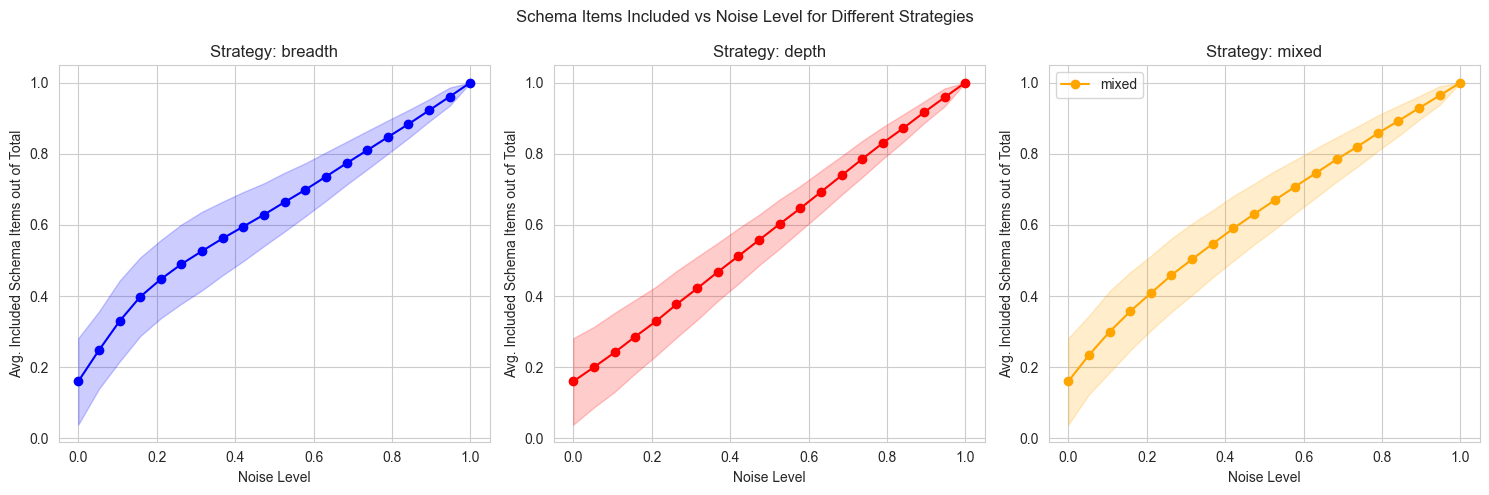

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
colors = {
    NoiseStrategy.BREADTH: 'blue',
    NoiseStrategy.DEPTH: 'red',
    NoiseStrategy.MIXED: 'orange'
}

for i, strategy in enumerate(NoiseStrategy):
    ax = axes[i]
    means = []
    stds = []
    for j, noise in enumerate(noise_levels):
        num_cols = [len(d[strategy.value]) / len(original[k]) for k, d in enumerate(linked[j])]
        means.append(np.mean(num_cols))
        stds.append(np.std(num_cols))
    ax.plot(noise_levels, means, color=colors[strategy], label=strategy.value, marker='o')
    ax.fill_between(noise_levels, np.array(means) - np.array(stds), np.array(means) + np.array(stds), color=colors[strategy], alpha=0.2)
    ax.set_title(f'Strategy: {strategy.value}')
    ax.set_xlabel('Noise Level')
    ax.set_ylabel('Avg. Included Schema Items out of Total')

plt.suptitle('Schema Items Included vs Noise Level for Different Strategies')
plt.legend()
plt.tight_layout()
plt.show()

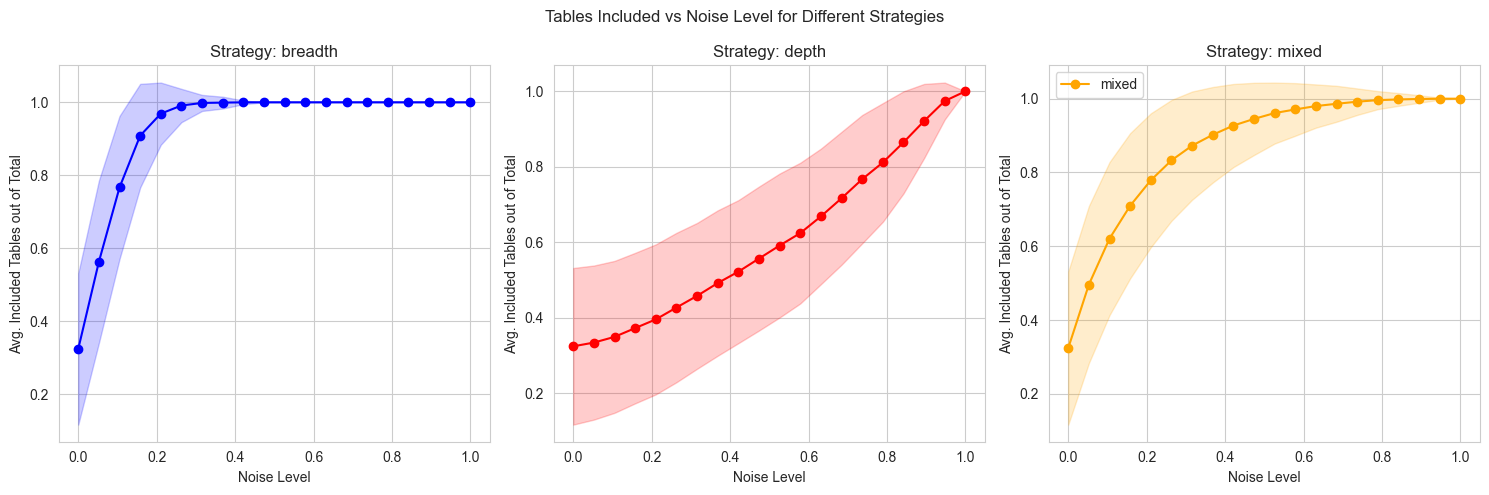

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
colors = {
    NoiseStrategy.BREADTH: 'blue',
    NoiseStrategy.DEPTH: 'red',
    NoiseStrategy.MIXED: 'orange'
}

for i, strategy in enumerate(NoiseStrategy):
    ax = axes[i]
    means = []
    stds = []
    for j, noise in enumerate(noise_levels):
        num_cols = [len(d[strategy.value].tables) / len(original[k].tables) for k, d in enumerate(linked[j])]
        means.append(np.mean(num_cols))
        stds.append(np.std(num_cols))
    ax.plot(noise_levels, means, color=colors[strategy], label=strategy.value, marker='o')
    ax.fill_between(noise_levels, np.array(means) - np.array(stds), np.array(means) + np.array(stds), color=colors[strategy], alpha=0.2)
    ax.set_title(f'Strategy: {strategy.value}')
    ax.set_xlabel('Noise Level')
    ax.set_ylabel('Avg. Included Tables out of Total')

plt.suptitle('Tables Included vs Noise Level for Different Strategies')
plt.legend()
plt.tight_layout()
plt.show()

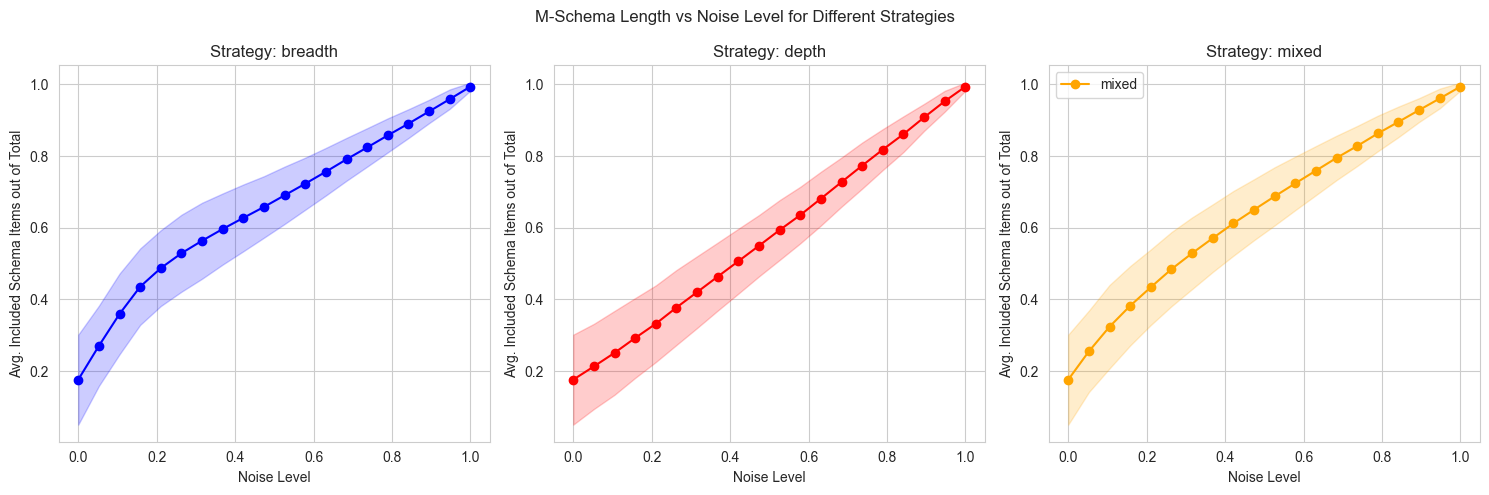

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
colors = {
    NoiseStrategy.BREADTH: 'blue',
    NoiseStrategy.DEPTH: 'red',
    NoiseStrategy.MIXED: 'orange'
}
for i, strategy in enumerate(NoiseStrategy):
    ax = axes[i]
    means = []
    stds = []
    for j, noise in enumerate(noise_levels):
        schema_length = [len(d[strategy.value].m_schema()) / len(original[k].m_schema()) for k, d in enumerate(linked[j])]
        means.append(np.mean(schema_length))
        stds.append(np.std(schema_length))
    ax.plot(noise_levels, means, color=colors[strategy], label=strategy.value, marker='o')
    ax.fill_between(noise_levels, np.array(means) - np.array(stds), np.array(means) + np.array(stds), color=colors[strategy], alpha=0.2)
    ax.set_title(f'Strategy: {strategy.value}')
    ax.set_xlabel('Noise Level')
    ax.set_ylabel('Avg. Included Schema Items out of Total')

plt.suptitle('M-Schema Length vs Noise Level for Different Strategies')
plt.legend()
plt.tight_layout()
plt.show()